In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [148]:
file_path = "large_extended_health_biomarkers_dataset - large_extended_health_biomarkers_dataset.csv"

In [149]:
data =  pd.read_csv(file_path)

In [70]:
#checking for missing values
# Check for missing values across all columns
missing_values = data.isnull().sum()

In [71]:
missing_values

Individual_ID               0
Gender                      0
Age                         0
Waist_Size_cm               0
Weight_kg                   0
Height_cm                   0
Date                        0
Steps                       0
Calories                    0
Sleep_Hours                 0
Glucose_Level               0
BP_Systolic                 0
BP_Diastolic                0
Meal_Plan_Adherence         0
Menstrual_Cycle        266040
Medicine_Taken              0
Mood                        0
Water_Intake_L              0
dtype: int64

In [72]:
# Identify outliers in continuous data using the IQR method
numeric_columns = ['Waist_Size_cm', 'Weight_kg', 'Height_cm', 'Steps', 'Calories', 
                   'Sleep_Hours', 'Glucose_Level', 'BP_Systolic', 'BP_Diastolic', 'Water_Intake_L']

In [73]:
#checking for outliers
outliers_info = {}
for col in numeric_columns:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers_info[col] = {
        "Lower Bound": lower_bound, 
        "Upper Bound": upper_bound, 
        "Outliers Count": ((data[col] < lower_bound) | (data[col] > upper_bound)).sum()
    }

In [74]:
outliers_info

{'Waist_Size_cm': {'Lower Bound': 51.11249999999997,
  'Upper Bound': 128.41250000000002,
  'Outliers Count': 0},
 'Weight_kg': {'Lower Bound': 25.237500000000004,
  'Upper Bound': 124.5375,
  'Outliers Count': 0},
 'Height_cm': {'Lower Bound': 125.74999999999997,
  'Upper Bound': 222.95000000000002,
  'Outliers Count': 0},
 'Steps': {'Lower Bound': -6042.5,
  'Upper Bound': 22049.5,
  'Outliers Count': 0},
 'Calories': {'Lower Bound': 500.0,
  'Upper Bound': 4500.0,
  'Outliers Count': 0},
 'Sleep_Hours': {'Lower Bound': 1.5499999999999998,
  'Upper Bound': 11.55,
  'Outliers Count': 0},
 'Glucose_Level': {'Lower Bound': 14.850000000000009,
  'Upper Bound': 235.25,
  'Outliers Count': 0},
 'BP_Systolic': {'Lower Bound': 65.0,
  'Upper Bound': 165.0,
  'Outliers Count': 0},
 'BP_Diastolic': {'Lower Bound': 45.0,
  'Upper Bound': 105.0,
  'Outliers Count': 0},
 'Water_Intake_L': {'Lower Bound': -1.0,
  'Upper Bound': 7.0,
  'Outliers Count': 0}}

In [75]:
#no outliers found

In [19]:
data['Menstrual_Cycle_Filled'] = data.apply(
    lambda row: row['Menstrual_Cycle'] if (row['Gender'] == 'Female') else 'Not Applicable', axis=1)

# For missing values in females, fill with mode ('No' in this case if majority)
female_mode = data[data['Gender'] == 'Female']['Menstrual_Cycle'].mode()[0]
data['Menstrual_Cycle_Filled'] = data['Menstrual_Cycle_Filled'].fillna(female_mode)

# Step 2: Add an indicator column for missing values in 'Menstrual_Cycle' for females
data['Menstrual_Cycle_Missing'] = data.apply(
    lambda row: 1 if (pd.isna(row['Menstrual_Cycle']) and row['Gender'] == 'Female') else 0, axis=1)

# Confirm the updates to the data preparation steps
prepared_data_sample = data[['Individual_ID', 'Gender', 'Menstrual_Cycle', 'Menstrual_Cycle_Filled', 'Menstrual_Cycle_Missing']].head(10)
prepared_data_sample

,Individual_ID,Gender,Menstrual_Cycle,Menstrual_Cycle_Filled,Menstrual_Cycle_Missing
0,1,Female,No,No,0
1,1,Female,No,No,0
2,1,Female,Yes,Yes,0
3,1,Female,Yes,Yes,0
4,1,Female,No,No,0
5,1,Female,No,No,0
6,1,Female,Yes,Yes,0
7,1,Female,Yes,Yes,0
8,1,Female,Yes,Yes,0
9,1,Female,No,No,0


In [20]:
missing_values = prepared_data_sample.isnull().sum()
missing_values

Individual_ID              0
Gender                     0
Menstrual_Cycle            0
Menstrual_Cycle_Filled     0
Menstrual_Cycle_Missing    0
dtype: int64

In [76]:
# Creating additional calculated metrics to aid in better visualizations and insights

# Assuming 'data' is the original DataFrame with multiple records per individual
# Create a new DataFrame with average values of key health markers for each individual
# Also include demographic and static information such as gender, age, weight, height, and waist size

# Group by 'Individual_ID' and calculate the mean for key health markers while keeping static information as is
individual_avg = data.groupby('Individual_ID').agg({
    'Gender': 'first',            # Gender remains the same across periods for each individual
    'Age': 'first',                # Age remains constant for each individual
    'Weight_kg': 'first',          # Static value per individual
    'Height_cm': 'first',          # Static value per individual
    'Waist_Size_cm': 'first',      # Static value per individual
    'Glucose_Level': 'mean',       # Average glucose level
    'BP_Systolic': 'mean',         # Average systolic blood pressure
    'BP_Diastolic': 'mean',        # Average diastolic blood pressure
    'Sleep_Hours': 'mean',         # Average sleep hours
    'Steps': 'mean',               # Average steps
    'Calories': 'mean',            # Average calories burned
    'Water_Intake_L': 'mean',      # Average water intake
                                  
}).reset_index()

# Display the new DataFrame with averaged key health markers and demographic info
individual_avg.head()

# Calculate adherence rates for each individual
adherence_metrics = data.groupby('Individual_ID').agg({
    'Meal_Plan_Adherence': 'mean',
    'Medicine_Taken': lambda x: (x == 'Yes').mean()  # Proportion of days medicine was taken
}).rename(columns={
    'Meal_Plan_Adherence': 'Meal_Plan_Adherence_Rate',
    'Medicine_Taken': 'Medicine_Adherence_Rate'
})

# Merge adherence metrics back into the main data on 'Individual_ID'
individual_avg = individual_avg.merge(adherence_metrics, on='Individual_ID', how='left')

# Calculate BMI and add to main data
individual_avg['Height_m'] = individual_avg['Height_cm'] / 100  # Convert height to meters
individual_avg['BMI'] = individual_avg['Weight_kg'] / (individual_avg['Height_m'] ** 2)

# Confirm the additional columns
prepared_data_sample = individual_avg
prepared_data_sample

,Individual_ID,Gender,Age,Weight_kg,Height_cm,Waist_Size_cm,Glucose_Level,BP_Systolic,BP_Diastolic,Sleep_Hours,Steps,Calories,Water_Intake_L,Meal_Plan_Adherence_Rate,Medicine_Adherence_Rate,Height_m,BMI
0,1,Female,53,74.5,178.9,101.8,123.586667,114.329444,76.045000,6.266667,8203.222222,2504.927778,3.043889,0.538889,0.488889,1.789,23.277460
1,2,Male,30,61.9,156.8,101.3,130.822778,116.880556,75.823889,6.442778,7763.850000,2508.877778,3.002222,0.455556,0.550000,1.568,25.176684
2,3,Male,52,72.1,162.0,92.2,126.648333,115.455000,73.932222,6.531111,7729.994444,2595.344444,3.069444,0.577778,0.394444,1.620,27.472946
3,4,Male,34,72.5,193.6,78.6,126.203889,114.645000,74.657778,6.545000,7461.438889,2480.700000,3.082778,0.566667,0.494444,1.936,19.343154
4,5,Male,25,79.1,174.4,103.0,122.968889,114.982222,74.553889,6.638889,7667.500000,2550.555556,3.072778,0.583333,0.494444,1.744,26.006597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,2996,Female,41,67.2,185.9,84.7,119.453889,114.935000,74.133333,6.531667,7820.705556,2582.638889,2.812222,0.500000,0.405556,1.859,19.445114
2996,2997,Female,34,76.7,188.2,75.2,124.250000,114.547778,74.843333,6.624444,8193.850000,2451.294444,3.031667,0.533333,0.494444,1.882,21.654897
2997,2998,Male,48,77.9,192.7,82.3,123.012222,115.576111,74.804444,6.405556,7588.661111,2474.338889,2.921667,0.583333,0.455556,1.927,20.978480
2998,2999,Male,51,66.7,170.8,89.3,121.075000,114.001111,74.800556,6.470556,7703.377778,2473.166667,2.949444,0.505556,0.544444,1.708,22.863889


In [77]:
# Rename columns in 'individual_avg' DataFrame to add "Avg_" prefix to averaged columns
# Exclude demographic/static information and adherence rate columns

# Define columns that need to be renamed with the "Avg_" prefix
columns_to_rename = {col: f"Avg_{col}" for col in prepared_data_sample.columns if col not in [
    'Individual_ID', 'Gender', 'Age', 'Weight_kg', 'Height_cm', 'Waist_Size_cm', 'Meal_Plan_Adherence_Rate', 'Medicine_Adherence_Rate', 'BMI'
]}

# Rename the columns
prepared_data_sample = prepared_data_sample.rename(columns=columns_to_rename)

# Display the updated DataFrame to confirm the changes
prepared_data_sample.head()


,Individual_ID,Gender,Age,Weight_kg,Height_cm,Waist_Size_cm,Avg_Glucose_Level,Avg_BP_Systolic,Avg_BP_Diastolic,Avg_Sleep_Hours,Avg_Steps,Avg_Calories,Avg_Water_Intake_L,Meal_Plan_Adherence_Rate,Medicine_Adherence_Rate,Avg_Height_m,BMI
0,1,Female,53,74.5,178.9,101.8,123.586667,114.329444,76.045000,6.266667,8203.222222,2504.927778,3.043889,0.538889,0.488889,1.789,23.277460
1,2,Male,30,61.9,156.8,101.3,130.822778,116.880556,75.823889,6.442778,7763.850000,2508.877778,3.002222,0.455556,0.550000,1.568,25.176684
2,3,Male,52,72.1,162.0,92.2,126.648333,115.455000,73.932222,6.531111,7729.994444,2595.344444,3.069444,0.577778,0.394444,1.620,27.472946
3,4,Male,34,72.5,193.6,78.6,126.203889,114.645000,74.657778,6.545000,7461.438889,2480.700000,3.082778,0.566667,0.494444,1.936,19.343154
4,5,Male,25,79.1,174.4,103.0,122.968889,114.982222,74.553889,6.638889,7667.500000,2550.555556,3.072778,0.583333,0.494444,1.744,26.006597


In [79]:
data.shape

(540000, 18)

In [81]:
mood

['Happy', 'Neutral', 'Anxious', 'Sad']

In [82]:
female = prepared_data_sample[prepared_data_sample['Gender']=='Female']

In [85]:
female

,Individual_ID,Gender,Age,Weight_kg,Height_cm,Waist_Size_cm,Avg_Glucose_Level,Avg_BP_Systolic,Avg_BP_Diastolic,Avg_Sleep_Hours,Avg_Steps,Avg_Calories,Avg_Water_Intake_L,Meal_Plan_Adherence_Rate,Medicine_Adherence_Rate,Avg_Height_m,BMI
0,1,Female,53,74.5,178.9,101.8,123.586667,114.329444,76.045000,6.266667,8203.222222,2504.927778,3.043889,0.538889,0.488889,1.789,23.277460
6,7,Female,38,87.2,199.6,81.0,126.742778,115.631667,74.985556,6.431111,7957.422222,2483.977778,3.086111,0.511111,0.522222,1.996,21.887462
10,11,Female,22,73.7,166.7,105.7,123.277778,116.440000,75.246667,6.478333,7706.855556,2405.977778,2.923333,0.527778,0.538889,1.667,26.521390
11,12,Female,31,73.0,183.9,85.2,122.411111,115.093889,73.754444,6.621111,8016.666667,2504.566667,3.003333,0.444444,0.538889,1.839,21.585365
12,13,Female,18,82.7,178.1,79.9,123.833889,114.287778,75.596111,6.595000,8432.266667,2451.794444,3.012222,0.472222,0.533333,1.781,26.072200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2989,2990,Female,36,57.0,162.2,78.8,126.605000,113.963889,75.438333,6.625556,8038.788889,2448.305556,2.896667,0.527778,0.555556,1.622,21.665721
2992,2993,Female,26,68.7,192.5,78.3,126.756111,115.715556,75.822778,6.488889,8091.672222,2536.933333,3.038889,0.477778,0.466667,1.925,18.539383
2995,2996,Female,41,67.2,185.9,84.7,119.453889,114.935000,74.133333,6.531667,7820.705556,2582.638889,2.812222,0.500000,0.405556,1.859,19.445114
2996,2997,Female,34,76.7,188.2,75.2,124.250000,114.547778,74.843333,6.624444,8193.850000,2451.294444,3.031667,0.533333,0.494444,1.882,21.654897


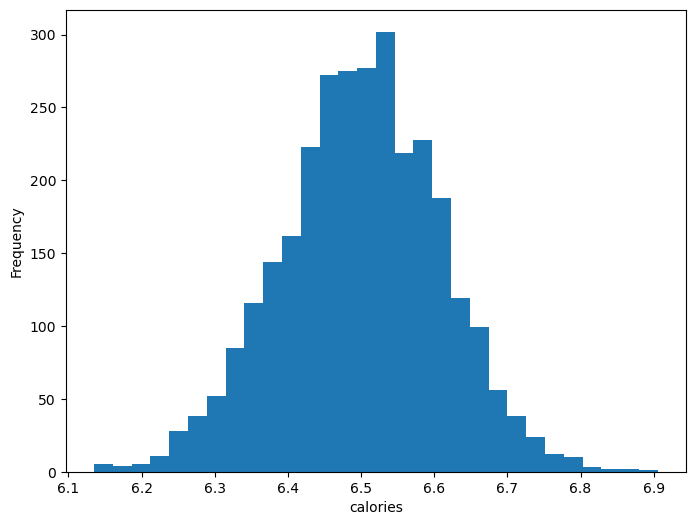

In [86]:
# Distribution of Key Metrices
plt.figure(figsize=(8, 6))
plt.hist(prepared_data_sample['Avg_Sleep_Hours'], bins=30)
plt.title('')
plt.xlabel('calories')
plt.ylabel('Frequency')
plt.show()

In [89]:
# Calculate skewness for each column in the DataFrame
skew_values = prepared_data_sample[['Avg_Steps', 'Avg_Calories', 'Avg_Glucose_Level', 'Avg_BP_Systolic', 'Avg_BP_Diastolic','Avg_Sleep_Hours','Avg_Water_Intake_L']].skew()
print(skew_values)


Avg_Steps            -0.011588
Avg_Calories         -0.004628
Avg_Glucose_Level     0.016647
Avg_BP_Systolic       0.017908
Avg_BP_Diastolic      0.007933
Avg_Sleep_Hours      -0.071056
Avg_Water_Intake_L   -0.068877
dtype: float64


Text(0, 0.5, 'Glucose Level (mg/dL)')

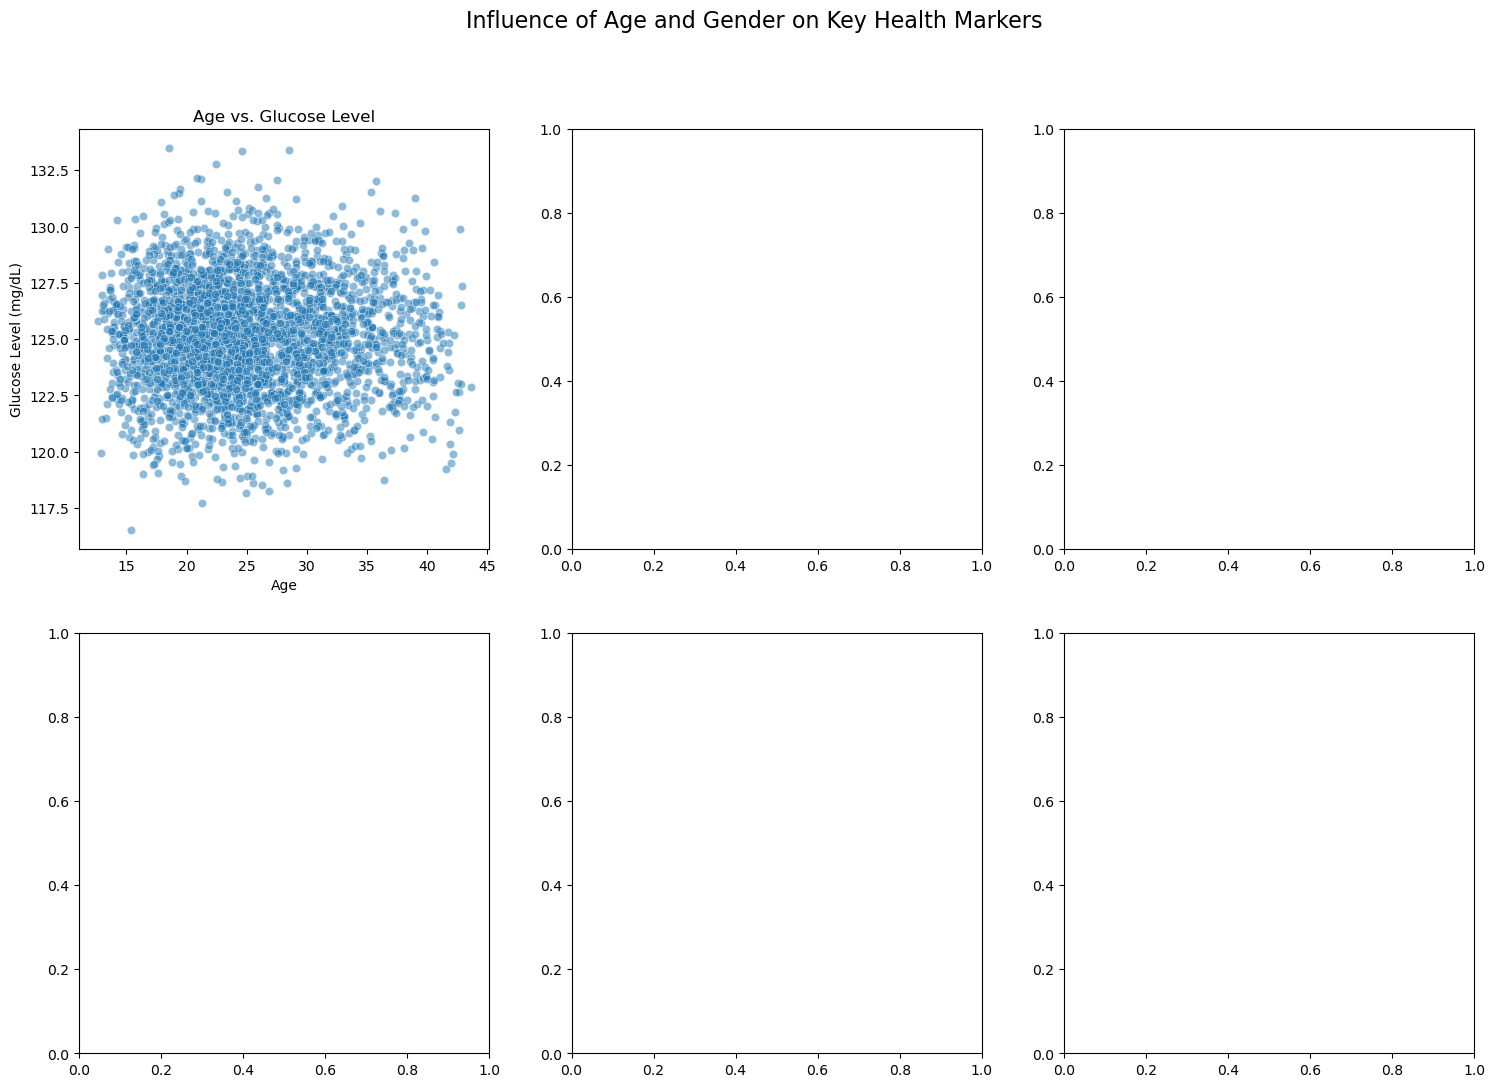

In [121]:
# Age vs key health markers
# Set up the plotting canvas for Age and Gender influences on health markers
fig, axs = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle("Influence of Age and Gender on Key Health Markers", fontsize=16)

# 1. Age vs. Glucose Levels
sns.scatterplot(prepared_data_sample, x='BMI', y='Avg_Glucose_Level', alpha=0.5, ax=axs[0, 0])
axs[0, 0].set_title('Age vs. Glucose Level')
axs[0, 0].set_xlabel('Age')
axs[0, 0].set_ylabel('Glucose Level (mg/dL)')

In [124]:
# Convert 'Gender' column in 'prepared_data_sample' DataFrame to binary values
# Assign Male = 1 and Female = 0

prepared_data_sample['Gender'] = prepared_data_sample['Gender'].map({'Male': 1, 'Female': 0})

# Display the updated DataFrame to confirm changes
prepared_data_sample.head()


,Individual_ID,Gender,Age,Weight_kg,Height_cm,Waist_Size_cm,Avg_Glucose_Level,Avg_BP_Systolic,Avg_BP_Diastolic,Avg_Sleep_Hours,Avg_Steps,Avg_Calories,Avg_Water_Intake_L,Meal_Plan_Adherence_Rate,Medicine_Adherence_Rate,Avg_Height_m,BMI
0,1,0,53,74.5,178.9,101.8,123.586667,114.329444,76.045000,6.266667,8203.222222,2504.927778,3.043889,0.538889,0.488889,1.789,23.277460
1,2,1,30,61.9,156.8,101.3,130.822778,116.880556,75.823889,6.442778,7763.850000,2508.877778,3.002222,0.455556,0.550000,1.568,25.176684
2,3,1,52,72.1,162.0,92.2,126.648333,115.455000,73.932222,6.531111,7729.994444,2595.344444,3.069444,0.577778,0.394444,1.620,27.472946
3,4,1,34,72.5,193.6,78.6,126.203889,114.645000,74.657778,6.545000,7461.438889,2480.700000,3.082778,0.566667,0.494444,1.936,19.343154
4,5,1,25,79.1,174.4,103.0,122.968889,114.982222,74.553889,6.638889,7667.500000,2550.555556,3.072778,0.583333,0.494444,1.744,26.006597


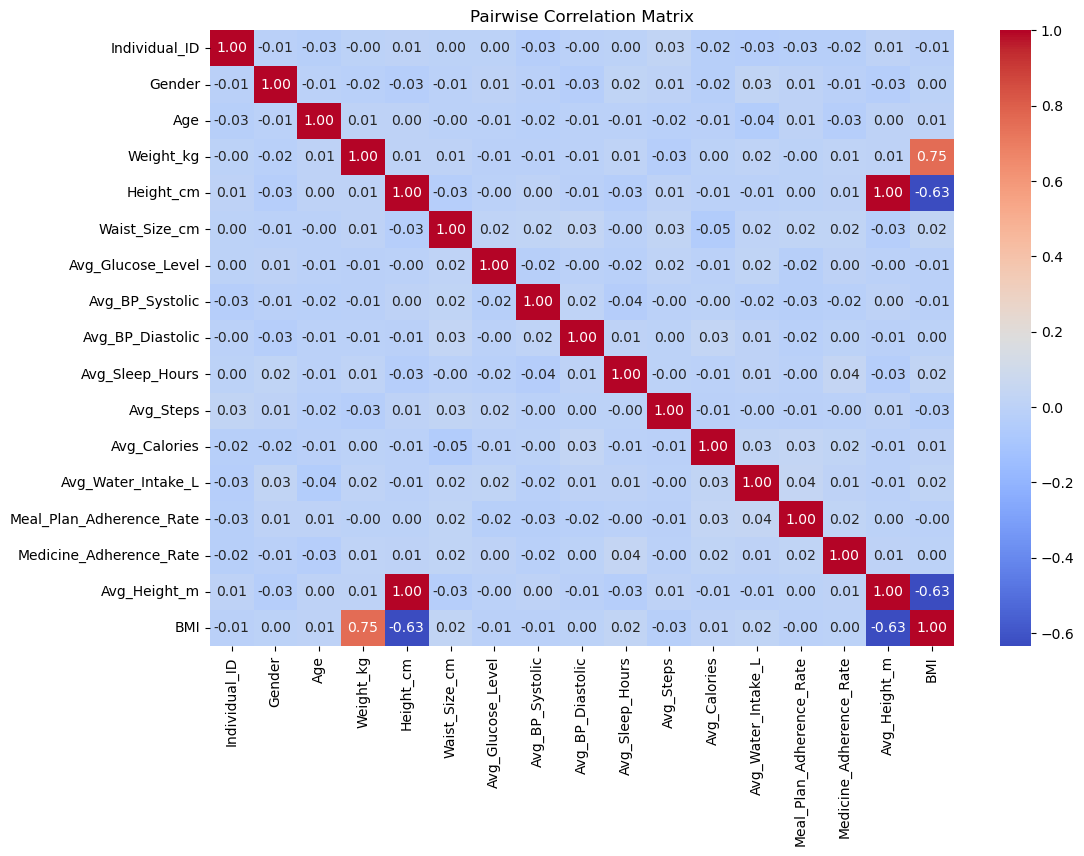

In [126]:
# Calculate pairwise correlation matrix
correlation_matrix = prepared_data_sample.corr()
# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Draw a heatmap with the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Pairwise Correlation Matrix")
plt.show()


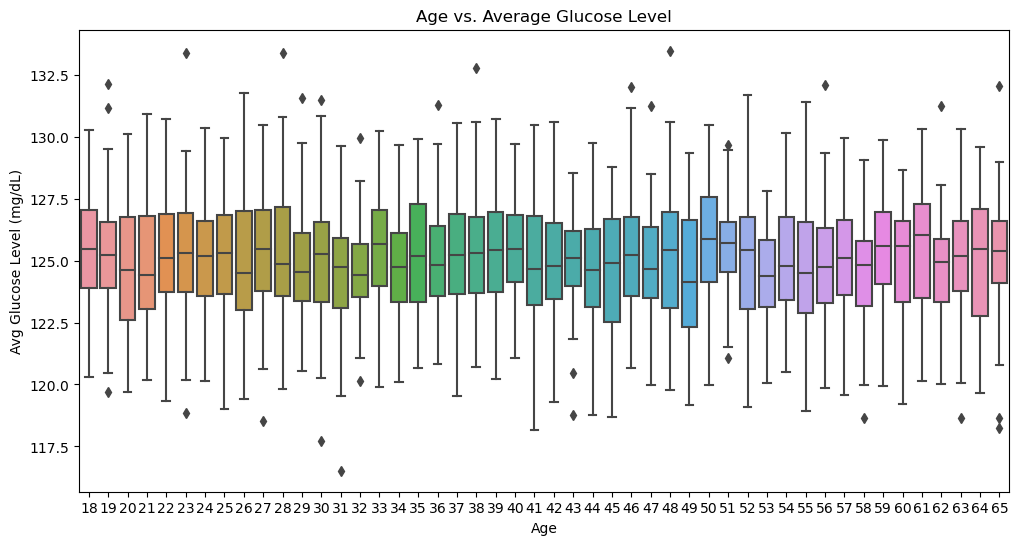

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot a boxplot for Age vs. Glucose Level
plt.figure(figsize=(12, 6))
sns.boxplot(prepared_data_sample, x='Age', y='Avg_Glucose_Level')
plt.title('Age vs. Average Glucose Level')
plt.xlabel('Age')
plt.ylabel('Avg Glucose Level (mg/dL)')
plt.show()


In [104]:
# Calculate the mean and standard deviation of key health markers for each age group
age_group_stats = prepared_data_sample.groupby('Age').agg({
    'Avg_Glucose_Level': ['mean', 'std'],
    'Avg_BP_Systolic': ['mean', 'std'],
    'Avg_BP_Diastolic': ['mean', 'std'],
    'Avg_Sleep_Hours': ['mean', 'std'],
    'Avg_Steps': ['mean', 'std'],
    'Avg_Calories': ['mean', 'std'],
    'Avg_Water_Intake_L': ['mean', 'std']
})

# Flatten the multi-level column index for readability
age_group_stats.columns = ['_'.join(col).strip() for col in age_group_stats.columns.values]
age_group_stats = age_group_stats.reset_index()

# Display the first few rows of the resulting DataFrame
age_group_stats



,Age,Avg_Glucose_Level_mean,Avg_Glucose_Level_std,Avg_BP_Systolic_mean,Avg_BP_Systolic_std,Avg_BP_Diastolic_mean,Avg_BP_Diastolic_std,Avg_Sleep_Hours_mean,Avg_Sleep_Hours_std,Avg_Steps_mean,Avg_Steps_std,Avg_Calories_mean,Avg_Calories_std,Avg_Water_Intake_L_mean,Avg_Water_Intake_L_std
0,18,125.361309,2.341295,114.974018,1.224353,74.985822,0.592559,6.490107,0.116751,7979.934323,267.252311,2502.811263,45.794773,3.016804,0.081276
1,19,125.250071,2.226780,115.063405,1.041857,74.998492,0.582373,6.485127,0.108634,7994.974921,288.406469,2506.169286,41.442552,3.010929,0.083462
2,20,124.810713,2.671687,114.902648,0.967246,75.027667,0.576598,6.506648,0.098127,8019.978519,299.605659,2508.851852,40.658135,3.012185,0.088850
3,21,124.918388,2.340216,115.228962,1.074203,75.047596,0.679291,6.519982,0.100528,7891.340437,303.780730,2491.688616,39.054701,3.020610,0.086010
4,22,125.086389,2.409947,115.341477,0.864865,74.937740,0.628394,6.470404,0.109721,8052.905429,328.528442,2504.421212,45.371744,2.972803,0.070596
5,23,125.190936,2.562504,114.945994,1.058993,75.065575,0.645120,6.514094,0.113628,8027.885575,286.947580,2492.464815,41.773645,3.004191,0.087453
6,24,125.130219,2.261030,115.083197,1.152122,74.857987,0.623574,6.499973,0.115785,7985.519399,334.670755,2499.176230,37.829801,2.989572,0.086968
7,25,125.243976,2.120941,114.925619,1.226323,74.876206,0.654164,6.501524,0.107746,7976.031032,278.980502,2497.317460,41.532963,3.005079,0.090638
8,26,125.030379,2.916014,115.018784,1.082536,75.019464,0.602767,6.496379,0.103235,8049.236405,251.297458,2502.821961,38.411431,3.000778,0.095058
9,27,125.291154,2.335638,115.045577,1.024751,74.945737,0.524871,6.473835,0.106251,8100.904808,307.872722,2497.786004,43.111474,3.005759,0.091904


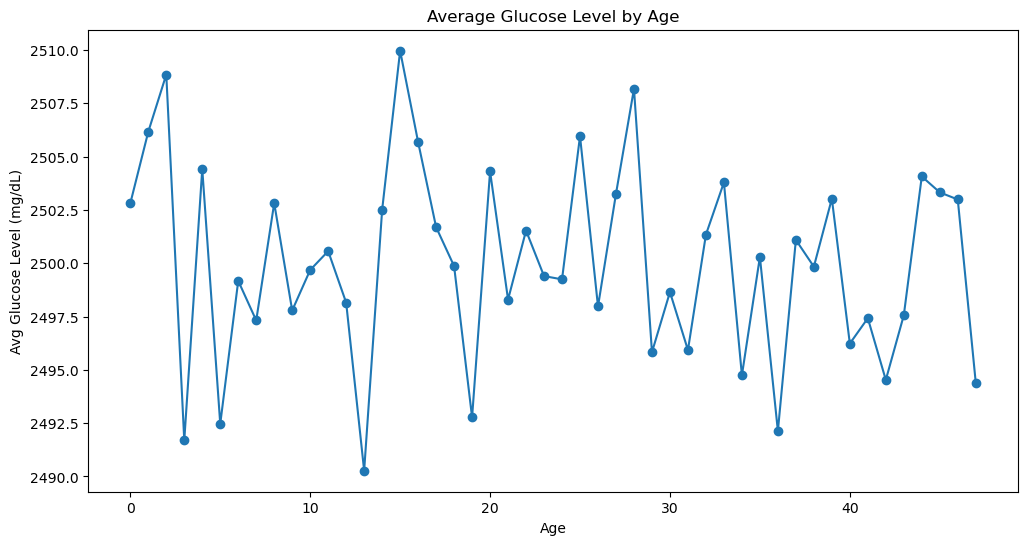

In [110]:
plt.figure(figsize=(12, 6))
plt.plot(age_group_stats.index, age_group_stats['Avg_Calories_mean'], marker='o')
plt.title('Average Glucose Level by Age')
plt.xlabel('Age')
plt.ylabel('Avg Glucose Level (mg/dL)')
plt.show()

In [127]:
data['Sleep_Hours'].describe()

count    540000.000000
mean          6.499927
std           1.443965
min           4.000000
25%           5.300000
50%           6.500000
75%           7.800000
max           9.000000
Name: Sleep_Hours, dtype: float64

In [141]:
low_sleep_group = data[data['Sleep_Hours'] < 6]
# Retrieve Individual_IDs for those with Sleep_Hours less than 6
low_sleep_individuals = low_sleep_group[['Individual_ID', 'Sleep_Hours']].drop_duplicates()

In [142]:
low_sleep_individuals.groupby('Individual_ID').mean()

,Sleep_Hours
Individual_ID,
1,4.936842
2,4.950000
3,4.950000
4,4.900000
5,4.950000
...,...
2996,4.950000
2997,4.952632
2998,4.921053


In [144]:
import ace_tools as tools
# Retrieve Individual_IDs and Dates for those with Sleep_Hours less than 6
low_sleep_dates = low_sleep_group[['Individual_ID', 'Date', 'Sleep_Hours']].drop_duplicates()

# Display the result to the user
tools.display_dataframe_to_user(name="Dates with Sleep Hours Less Than 6", dataframe=low_sleep_dates)

ModuleNotFoundError: No module named 'ace_tools'

In [145]:
pip install ace_tools

Note: you may need to restart the kernel to use updated packages.


In [150]:
prepared_data_sample['Avg_Glucose_Level'].describe()

count    3000.000000
mean      125.055939
std         2.395643
min       116.518333
25%       123.388333
50%       125.089444
75%       126.667361
max       133.472222
Name: Avg_Glucose_Level, dtype: float64

In [151]:
prepared_data_sample['BMI'].describe()

count    3000.000000
mean       25.044656
std         6.406635
min        12.625000
25%        20.291015
50%        24.298217
75%        29.260972
max        43.630695
Name: BMI, dtype: float64

In [152]:
prepared_data_sample['BMI'].quantile(0.9)

34.16496396751413

In [154]:
prepared_data_sample[prepared_data_sample['BMI']>=34.16496396751413]

,Individual_ID,Gender,Age,Weight_kg,Height_cm,Waist_Size_cm,Avg_Glucose_Level,Avg_BP_Systolic,Avg_BP_Diastolic,Avg_Sleep_Hours,Avg_Steps,Avg_Calories,Avg_Water_Intake_L,Meal_Plan_Adherence_Rate,Medicine_Adherence_Rate,Avg_Height_m,BMI
5,6,1,60,93.6,156.4,86.0,126.121111,114.448889,75.445000,6.472222,7497.850000,2466.427778,2.805556,0.572222,0.477778,1.564,38.265056
8,9,1,48,83.6,155.7,108.9,124.544444,114.570000,73.578333,6.501111,8162.694444,2487.388889,3.232222,0.544444,0.516667,1.557,34.484906
23,24,1,34,97.3,151.1,78.6,120.961667,114.749444,74.635556,6.716667,8356.283333,2478.138889,2.909444,0.500000,0.538889,1.511,42.617102
34,35,0,48,85.2,153.5,99.3,128.806667,114.005556,75.130556,6.581111,7490.761111,2530.455556,2.927222,0.511111,0.477778,1.535,36.159535
36,37,0,36,98.8,153.8,109.0,124.430556,114.550000,75.265000,6.426111,8310.027778,2534.138889,2.976111,0.550000,0.505556,1.538,41.768057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2945,2946,0,37,93.4,159.1,91.9,123.980000,112.607222,75.120556,6.652778,8204.616667,2472.111111,3.032222,0.466667,0.522222,1.591,36.898314
2959,2960,0,23,98.4,151.5,96.2,127.349444,113.139444,74.532778,6.740000,8003.744444,2490.022222,3.121111,0.455556,0.533333,1.515,42.871614
2973,2974,1,31,93.9,160.9,106.2,124.159444,114.921111,75.691111,6.453889,7618.711111,2587.594444,2.938333,0.438889,0.466667,1.609,36.270497
2983,2984,1,58,85.1,150.9,87.3,121.742222,114.629444,73.211111,6.230000,7669.694444,2491.766667,3.023889,0.505556,0.477778,1.509,37.372408


In [157]:
top_bmi_individuals = prepared_data_sample[prepared_data_sample['BMI'] >= 34.16496396751413]

# If you want only the unique individual IDs in the top 10% BMI group:
top_bmi_individual_ids = top_bmi_individuals['Individual_ID'].unique()


In [162]:
prepared_data_sample['Avg_BP_Systolic'].describe()

count    3000.000000
mean      114.972536
std         1.096433
min       110.972222
25%       114.224444
50%       114.982778
75%       115.708472
max       119.254444
Name: Avg_BP_Systolic, dtype: float64

In [163]:
data['BP_Systolic'].describe()

count    540000.000000
mean        114.972536
std          14.429710
min          90.000000
25%         102.500000
50%         115.000000
75%         127.500000
max         140.000000
Name: BP_Systolic, dtype: float64

In [164]:
data['BP_Systolic'].quantile(0.9)

135.0

In [180]:
top_BP_individuals = data[data['BP_Systolic'] >= 140]

# If you want only the unique individual IDs in the top 10% BMI group:
top_BP_individual_ids = top_BP_individuals['Individual_ID'].unique()

In [187]:
len(top_BP_individual_ids)

479

In [197]:
top_BP_individuals

,Individual_ID,Gender,Age,Waist_Size_cm,Weight_kg,Height_cm,Date,Steps,Calories,Sleep_Hours,Glucose_Level,BP_Systolic,BP_Diastolic,Meal_Plan_Adherence,Menstrual_Cycle,Medicine_Taken,Mood,Water_Intake_L
1588,9,Male,48,108.9,83.6,155.7,2024-08-31 06:57:13,1003,1773,6.7,133.8,140.0,79.8,1,NaN,No,Sad,2.2
2614,15,Female,23,102.8,62.8,160.2,2024-07-08 06:57:13,1260,1824,8.4,79.4,140.0,87.6,0,Yes,Yes,Happy,2.6
2712,16,Male,35,81.2,63.5,178.9,2024-04-17 06:57:13,11442,2838,4.6,145.8,140.0,78.5,1,NaN,Yes,Sad,1.9
2829,16,Male,35,81.2,63.5,178.9,2024-08-12 06:57:13,4385,3042,4.3,108.3,140.0,82.7,1,NaN,Yes,Sad,1.8
4090,23,Female,52,99.3,60.0,198.3,2024-08-13 06:57:13,10318,2178,7.4,77.1,140.0,61.0,0,No,No,Sad,4.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
533914,2967,Female,42,87.9,85.4,165.3,2024-05-09 06:57:13,7145,2982,4.7,77.6,140.0,66.0,0,Yes,No,Anxious,1.2
535577,2976,Male,30,109.8,63.1,154.1,2024-06-21 06:57:13,9940,2818,6.7,175.1,140.0,64.7,0,NaN,No,Sad,1.7
535802,2977,Male,19,84.7,50.0,153.7,2024-08-05 06:57:13,6522,2455,6.8,179.2,140.0,85.6,0,NaN,Yes,Happy,4.8
536320,2980,Male,45,77.6,72.7,166.4,2024-07-14 06:57:13,12517,2981,5.5,176.6,140.0,86.2,0,NaN,No,Happy,4.4


In [208]:
top_Glucose_individuals = prepared_data_sample[prepared_data_sample['Avg_Glucose_Level'] >= 126]

# If you want only the unique individual IDs in the top 10% BMI group:
top_Glucose_ids = top_Glucose_individuals['Individual_ID'].unique()

In [209]:
len(top_Glucose_ids)

1064

In [ ]:
# Health Markers thresholds
glucose = 126
bp_dis = 140
BMI = 34

In [210]:
# Save DataFrame to a CSV file
top_BP_individuals.to_csv("your_dataframe.csv", index=False)


In [212]:
# Add 'Frequency' column showing count of entries per individual
entry_counts = data['Individual_ID'].value_counts().reset_index()
entry_counts.columns = ['Individual_ID', 'Frequency']

# Merge 'Frequency' column into 'individual_avg'
prepared_data_sample= prepared_data_sample.merge(entry_counts, on='Individual_ID', how='left')


In [213]:
prepared_data_sample

,Individual_ID,Gender,Age,Weight_kg,Height_cm,Waist_Size_cm,Avg_Glucose_Level,Avg_BP_Systolic,Avg_BP_Diastolic,Avg_Sleep_Hours,Avg_Steps,Avg_Calories,Avg_Water_Intake_L,Meal_Plan_Adherence_Rate,Medicine_Adherence_Rate,Avg_Height_m,BMI,Frequency
0,1,0,53,74.5,178.9,101.8,123.586667,114.329444,76.045000,6.266667,8203.222222,2504.927778,3.043889,0.538889,0.488889,1.789,23.277460,180
1,2,1,30,61.9,156.8,101.3,130.822778,116.880556,75.823889,6.442778,7763.850000,2508.877778,3.002222,0.455556,0.550000,1.568,25.176684,180
2,3,1,52,72.1,162.0,92.2,126.648333,115.455000,73.932222,6.531111,7729.994444,2595.344444,3.069444,0.577778,0.394444,1.620,27.472946,180
3,4,1,34,72.5,193.6,78.6,126.203889,114.645000,74.657778,6.545000,7461.438889,2480.700000,3.082778,0.566667,0.494444,1.936,19.343154,180
4,5,1,25,79.1,174.4,103.0,122.968889,114.982222,74.553889,6.638889,7667.500000,2550.555556,3.072778,0.583333,0.494444,1.744,26.006597,180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,2996,0,41,67.2,185.9,84.7,119.453889,114.935000,74.133333,6.531667,7820.705556,2582.638889,2.812222,0.500000,0.405556,1.859,19.445114,180
2996,2997,0,34,76.7,188.2,75.2,124.250000,114.547778,74.843333,6.624444,8193.850000,2451.294444,3.031667,0.533333,0.494444,1.882,21.654897,180
2997,2998,1,48,77.9,192.7,82.3,123.012222,115.576111,74.804444,6.405556,7588.661111,2474.338889,2.921667,0.583333,0.455556,1.927,20.978480,180
2998,2999,1,51,66.7,170.8,89.3,121.075000,114.001111,74.800556,6.470556,7703.377778,2473.166667,2.949444,0.505556,0.544444,1.708,22.863889,180


In [214]:
top_Glucose_individuals

,Individual_ID,Gender,Age,Weight_kg,Height_cm,Waist_Size_cm,Avg_Glucose_Level,Avg_BP_Systolic,Avg_BP_Diastolic,Avg_Sleep_Hours,Avg_Steps,Avg_Calories,Avg_Water_Intake_L,Meal_Plan_Adherence_Rate,Medicine_Adherence_Rate,Avg_Height_m,BMI
1,2,1,30,61.9,156.8,101.3,130.822778,116.880556,75.823889,6.442778,7763.850000,2508.877778,3.002222,0.455556,0.550000,1.568,25.176684
2,3,1,52,72.1,162.0,92.2,126.648333,115.455000,73.932222,6.531111,7729.994444,2595.344444,3.069444,0.577778,0.394444,1.620,27.472946
3,4,1,34,72.5,193.6,78.6,126.203889,114.645000,74.657778,6.545000,7461.438889,2480.700000,3.082778,0.566667,0.494444,1.936,19.343154
5,6,1,60,93.6,156.4,86.0,126.121111,114.448889,75.445000,6.472222,7497.850000,2466.427778,2.805556,0.572222,0.477778,1.564,38.265056
6,7,0,38,87.2,199.6,81.0,126.742778,115.631667,74.985556,6.431111,7957.422222,2483.977778,3.086111,0.511111,0.522222,1.996,21.887462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2988,2989,0,43,70.1,154.1,94.4,127.585556,114.896667,73.953333,6.549444,7941.744444,2509.305556,2.957778,0.522222,0.461111,1.541,29.519754
2989,2990,0,36,57.0,162.2,78.8,126.605000,113.963889,75.438333,6.625556,8038.788889,2448.305556,2.896667,0.527778,0.555556,1.622,21.665721
2990,2991,1,53,88.6,183.2,77.6,126.422222,113.800556,74.535556,6.394444,8051.477778,2486.988889,3.083333,0.500000,0.527778,1.832,26.398715
2992,2993,0,26,68.7,192.5,78.3,126.756111,115.715556,75.822778,6.488889,8091.672222,2536.933333,3.038889,0.477778,0.466667,1.925,18.539383


In [215]:
data['Glucose_Level'].describe()

count    540000.000000
mean        125.055939
std          31.762948
min          70.000000
25%          97.500000
50%         125.100000
75%         152.600000
max         180.000000
Name: Glucose_Level, dtype: float64

In [216]:
prepared_data_sample['Avg_Glucose_Level'].describe()

count    3000.000000
mean      125.055939
std         2.395643
min       116.518333
25%       123.388333
50%       125.089444
75%       126.667361
max       133.472222
Name: Avg_Glucose_Level, dtype: float64

In [217]:
prepared_data_sample.to_csv("avg_data.csv", index=False)
